## Sampling with Stochastic Gradient Langevin Dynamics 

Ulysse Marteau-Ferey, Umut Simsekli

The goal of this practical session is to implement the Stochastic Gradient Langevin Dynamics (SGLD -- Welling & Teh, ICML 2011) algorithm in order to draw samples from the posterior distribution of a Gaussian probabilistic model.

While this task might seem "synthetic" at a first glance, it has an important role in scientific studies: We will design the probabilistic model in a way that the posterior distribution can be computed analytically. This approach will enable us to measure the performance of our algorithm, since the answer that we would like to find in the beginning is already known; hence, we can compare our results to the "ground truth". This is very standard practice in academic studies.

The roadmap for the TD is as follows:

- After defining the probabilistic model, we will first generate a dataset from it.
- We will compute the posterior distribution / posterior expectations in closed form (which will be used for measuring the performance of SGLD later on)
- We will implement the SGLD algorithm measure its performance with respect changing hyperparameters (step-size, batch-size)


### The probabilistic model

Let $\theta$ be a random variable in $\mathbb{R}$, $n \in \mathbb{N}_+$ be fixed and $\{a_i \in \mathbb{R}\}_{i=1}^n$ be a **given** sequence of real numbers. We will consider the following probabilistic model.   

\begin{align}
\theta \sim& \mathcal{N}(0,\sigma_\theta^2) \\
y_i | \theta \sim& \mathcal{N}(a_i \theta,\sigma_Y^2), \qquad \text{for } i=1,\dots,n ,
\end{align}
where $\mathcal{N}$ denotes the Gaussian distribution. To make the notation clear, if a random variable $X\sim \mathcal{N}(\mu, \sigma^2)$, then it admits the following probabilit density function:
\begin{align}
p_X(x) = \frac1{\sqrt{2\pi \sigma^2}} \exp(- \frac1{2\sigma^2}(x-\mu)^2)
\end{align}

In [1]:
# Required imports

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


### Q1 - Data Generation

- Set $n = 1000$, $\sigma_\theta^2  = 10$, $\sigma_Y^2 = 2$.
- Generate random $\{a_i\}_{i=1}^n$ such that $a_i \sim \mathcal{N}(0, 1)$. 
- By fixing the values for $a_i$s, simulate the probabilistic model
    - First generate a $\theta_{\text{true}}$ from the prior
    - Then fix $\theta_{\text{true}}$ and generate $\{y_i\}_{i=1}^n$

In [2]:
#ANSWER

n = 1000
sig_theta = 10
sig_Y = 2

a = np.sqrt(1) * np.random.randn(n)
theta_true = np.sqrt(sig_theta) * np.random.randn()
y = a*theta_true + np.sqrt(sig_Y) * np.random.randn(n)

### Q2 - Computing the Posterior in Closed-Form

By denoting the prior distribution by $p(\theta)$ and the likelihood by $p(D_n|\theta)$, such that $D_n = \{y_1,\dots, y_n\}$, compute the posterior distribution $p(\theta|D_n)$ in analytical form.


### Answer.

Here, we will use a common trick where we will only keep track of variables that depend on $\theta$. More precisely, if $X\sim \mathcal{N}(\mu,\sigma^2)$, we can write its log-density as follows:
\begin{align}
\log p_X(x) =^+& -\frac{(x-\mu)^2}{2\sigma^2}\\
=^+& -\frac{x^2- 2x\mu}{2\sigma^2} \\
=& -\frac{x^2}{2\sigma^2} + \frac{x\mu}{\sigma^2}
\end{align}
where $=^+$ denotes equality up to constants that do not depend on $x$. Here, we can see that the coefficient associated to $x^2$ is $\frac1{2 \sigma ^2}$ and the coefficient associated to $x$ is $\frac{\mu}{\sigma^2}$. To ease the computations, we will make use of this information. 

We have 
\begin{align}
\log p(\theta) =^+& -\frac{\theta^2}{2\sigma_\theta^2} \\
\log p(y_i| \theta) =^+& \frac{(y_i - a_i \theta)^2}{2\sigma_Y^2},
\end{align}
where $=^+$ denotes equality up to constants that do not depend on $\theta$. Hence, we have

\begin{align}
\log p(\theta | D_n) =^+& \log p(D_n|\theta) + \log p(\theta) \\
=^+& -\sum_{i=1}^n \frac{(y_i - a_i \theta)^2}{2\sigma_Y^2} -\frac{\theta^2}{2\sigma_\theta^2} \\
=^+& -\sum_{i=1}^n \frac{-2 y_i a_i \theta + a_i^2 \theta^2}{2\sigma_Y^2} -\frac{\theta^2}{2\sigma_\theta^2} \\
=^+& - \theta^2 \Bigl( \sum_{i=1}^n \frac{a_i^2 }{2\sigma_Y^2} + \frac{1}{2\sigma_\theta^2} \Bigr) + \theta \sum_{i=1}^n \frac{ y_i a_i}{\sigma_Y^2}.
\end{align}

Hence, by using the relation that we used in the beginning of this cell, we can conlude that 

$$ p(\theta|D_n) = \mathcal{N}(\mu_{\text{post}},\sigma_{\text{post}}^2),$$

where 

\begin{align}
\sigma_{\text{post}}^2 =& \frac1{2 ( \sum_{i=1}^n \frac{a_i^2 }{2\sigma_Y^2} + \frac{1}{2\sigma_\theta^2} )} = \frac1{  \frac{ \sum_{i=1}^n a_i^2 }{\sigma_Y^2} + \frac{1}{\sigma_\theta^2} } = \frac{\sigma_\theta^2 \sigma_Y^2}{ \sigma_\theta^2  \sum_{i=1}^n a_i^2  + \sigma_Y^2 }, \\
\mu_{\text{post}} =& \frac{\sigma_{\text{post}}^2} {\sigma_Y^2} \sum_{i=1}^n  y_i a_i.
\end{align}

### Q3 - Running SGLD

At this step, we will implement the SGLD algorithm to draw approximate samples from $p(\theta|D_n)$ by only using the prior density and the likelihood (i.e, we will not use the analytical form that we computed in the previous step). 

The SGLD algorithm is based on the following simple recursion:

\begin{align}
\theta_{k+1} = \theta_{k} - \eta \nabla \hat{U}_{k+1} (\theta_k) + \sqrt{2\eta} Z_{k+1},
\end{align}

where, $\eta>0$ is a small step-size, $Z_{k} \sim \mathcal{N}(0,1)$ is a standard Gaussian random variable (for all $k$), and 

$$\hat{U}_k(\theta) := \hat{U}_{\Omega_k}(\theta) := -\frac{n}{b} \sum_{i \in \Omega_k} \log p(y_i|\theta) - \log p(\theta). $$

Here, $\Omega_k \subset \{1,\dots,n\}$ is a random data subsample that is drawn with or without replacement at each iteration, and $b = |\Omega_k|$ denotes the number of elements in $\Omega_k$, also known as batch-size.


- Implement the SGLD algorithm for the given model
- Set $\eta = 0.001$, $b = n$ (use all the data points at every iteration) and run the algorithm for $K=10000$ iterations. Discard the first $K_{\text{burn in}} = 5000$ (this is called the "burn-in period" -- also think about why this is necessary) iterations and plot the histogram of the last $5000$ iterates. Also plot the true density of the posterior distribution. Do they look similar? 

Assume that we want to estimate the second-moment of the posterior distribution, i.e.

$$ \mathbb{E}_{\theta \sim p(\theta|D_n)} [\theta^2] = \int_{\mathbb{R}} \theta^2 p(\theta|D_n) d\theta. $$

Now consider the corresponding SGLD estimator: (why does this make sense?)

$$ \hat{\theta^2} := \frac1{K - K_{\text{burn in}}} \sum_{k = K_{\text{burn in}} +1}^K  \theta_k^2. $$

Does the SGLD estimator provide reasonable estimates?

Play with the parameters $\eta$ and $b$. What do you observe?


In [7]:
# Answer

def sgld(a, y, sig_theta, sig_Y, eta, b, K):
    thetas = np.zeros(K)

    thetas[0] = np.sqrt(sig_theta) * np.random.randn()

    for k in range(K-1):
        Omega = np.random.permutation(n)[0:b]
        a_k = a[Omega]
        y_k = y[Omega]

        grad = (n/b)* np.sum( a_k * (a_k*thetas[k] - y_k)  ) / (sig_Y) + thetas[k] / sig_theta
        thetas[k+1] = thetas[k] - eta * grad + np.sqrt(2 * eta) * np.random.randn()
    
    return thetas

In [8]:
# True Posterior Parameters
sig_post = (sig_theta * sig_Y) / (sig_theta * np.sum(a**2) + sig_Y )
mu_post  = (sig_post/sig_Y) * np.sum(y*a)

eta = 0.001
b = n
K = 10000

thetas = sgld(a, y, sig_theta, sig_Y, eta, b, K)

In [10]:
thetas

array([-2.66957481, -0.41389176,  0.56904877, ...,  1.39030145,
        1.42228125,  1.44781299])

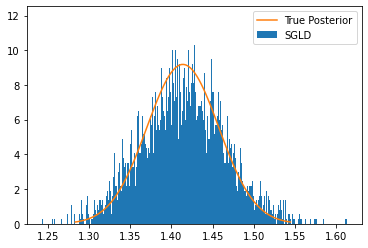

In [9]:
#Visualization

res = plt.hist(thetas[int(K/2):K],density=True, bins=500, label="SGLD")

x = np.linspace(mu_post - 3*np.sqrt(sig_post), mu_post + 3*np.sqrt(sig_post), 100)
plt.plot(x, stats.norm.pdf(x, mu_post, np.sqrt(sig_post)), label="True Posterior")
plt.legend()

In [6]:
print("True Value: ",sig_post + mu_post**2)
print("SGLD Estimate: ",np.mean(thetas[5000:K]**2))

True Value:  2.0008169034681664
SGLD Estimate:  1.9996003411461898
